In this notebook, we will try to train a XGBoost model using permissions from 4287 benign and 3876 malicious android applications.

<h1>Loading Data</h1>

In [24]:
permissions_df = pd.read_csv('../catch-o-extractor/extracted_permissions.csv')
labeled_data_df = pd.read_csv('../catch-o-labeler/labeled_data.csv')

permissions_df = permissions_df.drop(permissions_df.columns[1], axis=1)
permissions_df = permissions_df.rename(columns={permissions_df.columns[0]: 'name'})

In [25]:
df = permissions_df.merge(labeled_data_df, left_on='name', right_on='hash', how='left')

df['detection'] = df['detection'].fillna('benign')

df = df.drop(columns=['hash'])


<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train using Permissions.
For convenience, here on out we will use the already exported data.

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("permissions_labeled_dataset.csv")

In [38]:
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, replace=True)
other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples]).reset_index(drop=True)
df['detection'].value_counts()

/tmp/ipykernel_188226/2932402478.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)


detection
benign      1000
adware       200
exploit      200
hacktool     200
spyware      200
trojan       200
Name: count, dtype: int64

In [39]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [40]:
# Encode string labels into numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



<h1>Training the XGBoost Classifier</h1>

In [41]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Generate predictions
y_pred = xgb_clf.predict(X_test)

/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [42]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print the classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9375
              precision    recall  f1-score   support

      adware       0.82      0.91      0.86        34
      benign       0.97      0.97      0.97       199
     exploit       0.88      0.91      0.90        33
    hacktool       0.98      0.95      0.97        44
     spyware       0.94      0.96      0.95        48
      trojan       0.91      0.76      0.83        42

    accuracy                           0.94       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.94      0.94      0.94       400



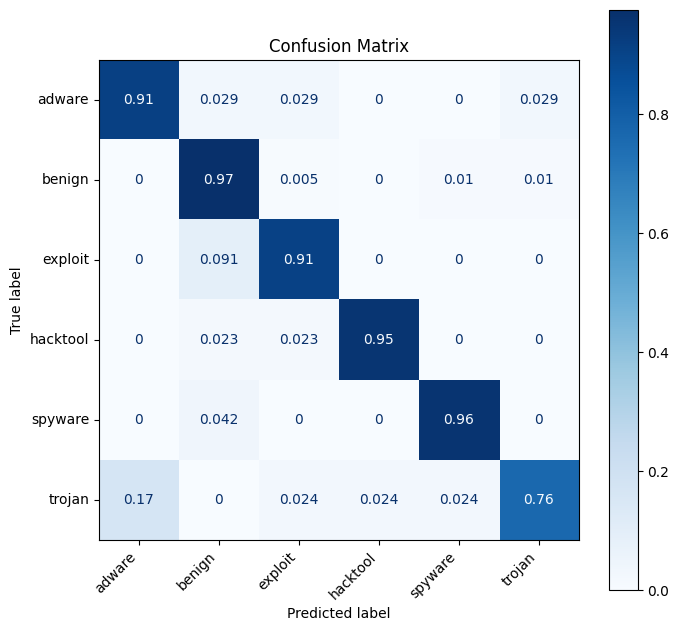

In [43]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

In [44]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Generate predicted probabilities
y_pred_proba = xgb_clf.predict_proba(X_test)

# Binarize the output
classes = label_encoder.classes_
y_test_bin = label_binarize(y_test, classes=range(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


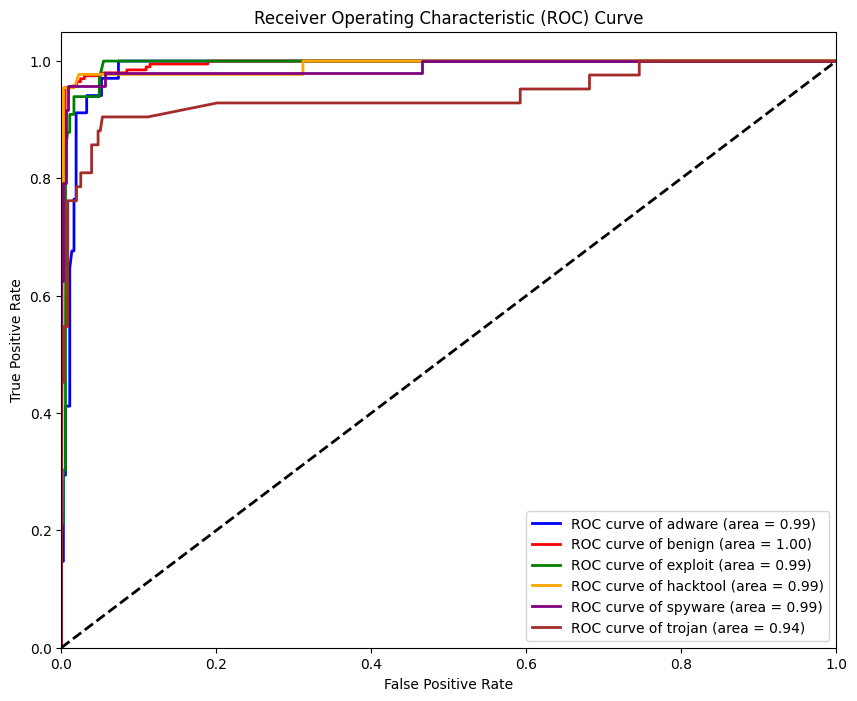

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i, color, cls in zip(range(len(classes)), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {cls} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


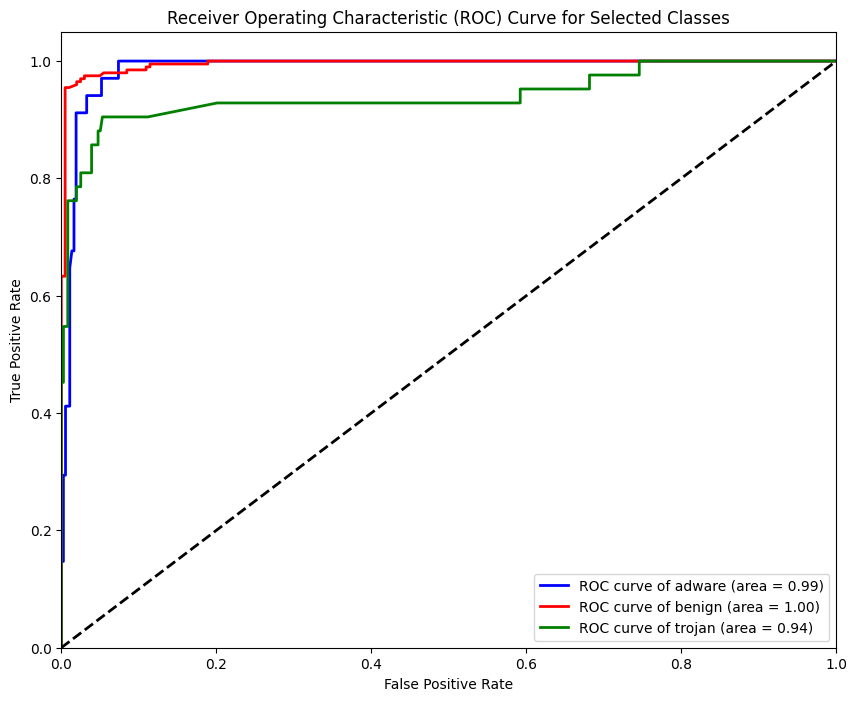

In [46]:
# Plot ROC curves for selected classes
selected_classes = ['adware', 'benign', 'trojan']  # Example of selected classes
colors = ['blue', 'red', 'green']
plt.figure(figsize=(10, 8))
for i, cls in enumerate(selected_classes):
    idx = list(label_encoder.classes_).index(cls)
    plt.plot(fpr[idx], tpr[idx], color=colors[i], lw=2, label=f'ROC curve of {cls} (area = {roc_auc[idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Selected Classes')
plt.legend(loc="lower right")
plt.show()


In [47]:
from sklearn.metrics import hamming_loss, balanced_accuracy_score, cohen_kappa_score

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)

# Hamming Loss
hamming = hamming_loss(y_test, y_pred)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Cohen's Kappa: {kappa}")
print(f"Hamming Loss: {hamming}")
print(f"Balanced Accuracy: {balanced_acc}")

Cohen's Kappa: 0.9106129271584743
Hamming Loss: 0.0625
Balanced Accuracy: 0.9117522561026847
